# Method 6 - Best Minus Rest

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Market Relative Weight per Shumway, Szefler, Yuan 2009

%store -r mkt_exp_ret

valid_data = valid_data.merge(mkt_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] == 1].copy()                                                                           
short_ideas = valid_data[valid_data['pos_rank'] != 1].copy()

# Weight the best ideas equally

long_ideas['target'] = 1 / long_ideas.groupby('datadate')[
    'institution_id'].transform('count')

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

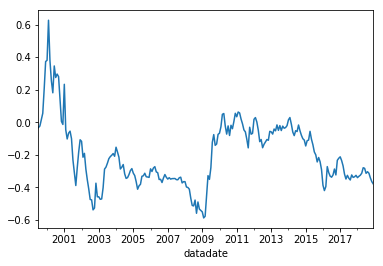

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.372749
2000-12-31   -0.281288
2001-12-31   -0.095476
2002-12-31   -0.392499
2003-12-31    0.459228
2004-12-31   -0.095780
2005-12-31   -0.075305
2006-12-31    0.000595
2007-12-31   -0.040354
2008-12-31   -0.277805
2009-12-31    1.017697
2010-12-31    0.139960
2011-12-31   -0.116575
2012-12-31    0.013037
2013-12-31    0.037172
2014-12-31   -0.090519
2015-12-31   -0.203792
2016-12-31    0.098494
2017-12-31   -0.134775
2018-12-31   -0.078142
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     89.12
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-45
Time:                        14:07:14   Log-Likelihood:                 389.54
No. Observations:                 234   AIC:                            -769.1
Df Residuals:                     229   BIC:                            -751.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.003      0.936      0.350      -0.003       0.009
mktrf          0.3375      0.086      3.909      0.000       0.167       0.508
me             0.3491      0.100      3.476      0.001       0.151       0.547
ia            -0.1002      0.153     -0.656      0.512      -0.401       0.201
roe           -1.3561      0.131    -10.380      0.000      -1.614      -1.099
==============================================================================
Omnibus:                      136.520   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1568.496
Skew:                           2.033   Prob(JB):                         0.00
Kurtosis:                      15.014   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     101.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-49
Time:                        14:07:14   Log-Likelihood:                 389.54
No. Observations:                 234   AIC:                            -769.1
Df Residuals:                     229   BIC:                            -751.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.003      0.927      0.354      -0.003       0.009
mktrf          0.3375      0.154      2.198      0.028       0.037       0.638
me             0.3491      0.107      3.274      0.001       0.140       0.558
ia            -0.1002      0.223     -0.448      0.654      -0.538       0.338
roe           -1.3561      0.209     -6.490      0.000      -1.766      -0.947
==============================================================================
Omnibus:                      136.520   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1568.496
Skew:                           2.033   Prob(JB):                         0.00
Kurtosis:                      15.014   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.602
Method:                 Least Squares   F-statistic:                     124.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.47e-56
Time:                        14:07:14   Log-Likelihood:                 389.54
No. Observations:                 234   AIC:                            -769.1
Df Residuals:                     229   BIC:                            -751.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0030      0.003      0.845      0.398      -0.004       0.010
mktrf          0.3375      0.152      2.226      0.026       0.040       0.635
me             0.3491      0.119      2.925      0.003       0.115       0.583
ia            -0.1002      0.227     -0.442      0.658      -0.544       0.344
roe           -1.3561      0.217     -6.242      0.000      -1.782      -0.930
==============================================================================
Omnibus:                      136.520   Durbin-Watson:                   2.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1568.496
Skew:                           2.033   Prob(JB):                         0.00
Kurtosis:                      15.014   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     59.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.95e-39
Time:                        14:07:14   Log-Likelihood:                 377.34
No. Observations:                 234   AIC:                            -742.7
Df Residuals:                     228   BIC:                            -721.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.003      0.612      0.541      -0.005       0.009
mktrf          0.4655      0.091      5.097      0.000       0.286       0.645
smb            0.3558      0.121      2.953      0.003       0.118       0.593
hml            0.1602      0.142      1.127      0.261      -0.120       0.440
rmw           -1.2473      0.161     -7.763      0.000      -1.564      -0.931
cma           -0.0093      0.204     -0.046      0.964      -0.412       0.393
==============================================================================
Omnibus:                      143.364   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1192.565
Skew:                           2.321   Prob(JB):                    1.09e-259
Kurtosis:                      13.038   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     27.04
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.90e-21
Time:                        14:07:14   Log-Likelihood:                 377.34
No. Observations:                 234   AIC:                            -742.7
Df Residuals:                     228   BIC:                            -721.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.578      0.563      -0.005       0.009
mktrf          0.4655      0.114      4.084      0.000       0.242       0.689
smb            0.3558      0.117      3.038      0.002       0.126       0.585
hml            0.1602      0.219      0.732      0.464      -0.269       0.589
rmw           -1.2473      0.226     -5.509      0.000      -1.691      -0.804
cma           -0.0093      0.326     -0.029      0.977      -0.648       0.630
==============================================================================
Omnibus:                      143.364   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1192.565
Skew:                           2.321   Prob(JB):                    1.09e-259
Kurtosis:                      13.038   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     28.24
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.07e-22
Time:                        14:07:14   Log-Likelihood:                 377.34
No. Observations:                 234   AIC:                            -742.7
Df Residuals:                     228   BIC:                            -721.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.004      0.519      0.604      -0.006       0.010
mktrf          0.4655      0.102      4.581      0.000       0.266       0.665
smb            0.3558      0.115      3.092      0.002       0.130       0.581
hml            0.1602      0.167      0.957      0.338      -0.168       0.488
rmw           -1.2473      0.235     -5.305      0.000      -1.708      -0.786
cma           -0.0093      0.318     -0.029      0.977      -0.632       0.614
==============================================================================
Omnibus:                      143.364   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1192.565
Skew:                           2.321   Prob(JB):                    1.09e-259
Kurtosis:                      13.038   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     78.82
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.01e-42
Time:                        14:07:14   Log-Likelihood:                 381.00
No. Observations:                 234   AIC:                            -752.0
Df Residuals:                     229   BIC:                            -734.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.410      0.682      -0.008       0.005
mktrf          0.5194      0.082      6.301      0.000       0.357       0.682
smb            0.9767      0.103      9.491      0.000       0.774       1.179
hml           -0.2379      0.102     -2.327      0.021      -0.439      -0.036
umd           -0.5417      0.067     -8.076      0.000      -0.674      -0.410
==============================================================================
Omnibus:                      127.584   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1190.168
Skew:                           1.935   Prob(JB):                    3.62e-259
Kurtosis:                      13.348   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     44.11
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.99e-27
Time:                        14:07:14   Log-Likelihood:                 381.00
No. Observations:                 234   AIC:                            -752.0
Df Residuals:                     229   BIC:                            -734.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.469      0.639      -0.007       0.004
mktrf          0.5194      0.129      4.021      0.000       0.266       0.773
smb            0.9767      0.106      9.192      0.000       0.768       1.185
hml           -0.2379      0.154     -1.544      0.123      -0.540       0.064
umd           -0.5417      0.108     -5.000      0.000      -0.754      -0.329
==============================================================================
Omnibus:                      127.584   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1190.168
Skew:                           1.935   Prob(JB):                    3.62e-259
Kurtosis:                      13.348   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     46.77
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.06e-28
Time:                        14:07:14   Log-Likelihood:                 381.00
No. Observations:                 234   AIC:                            -752.0
Df Residuals:                     229   BIC:                            -734.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.003     -0.460      0.645      -0.007       0.004
mktrf          0.5194      0.123      4.226      0.000       0.279       0.760
smb            0.9767      0.101      9.655      0.000       0.778       1.175
hml           -0.2379      0.153     -1.557      0.120      -0.537       0.062
umd           -0.5417      0.107     -5.078      0.000      -0.751      -0.333
==============================================================================
Omnibus:                      127.584   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1190.168
Skew:                           1.935   Prob(JB):                    3.62e-259
Kurtosis:                      13.348   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     46.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.82e-23
Time:                        14:07:14   Log-Likelihood:                 179.10
No. Observations:                 120   AIC:                            -348.2
Df Residuals:                     115   BIC:                            -334.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.005      1.342      0.182      -0.003       0.018
mktrf          0.2322      0.143      1.621      0.108      -0.051       0.516
me             0.2637      0.141      1.864      0.065      -0.017       0.544
ia            -0.3465      0.222     -1.564      0.121      -0.785       0.092
roe           -1.3853      0.196     -7.065      0.000      -1.774      -0.997
==============================================================================
Omnibus:                       61.988   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              353.328
Skew:                           1.647   Prob(JB):                     1.89e-77
Kurtosis:                      10.734   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     120.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.24e-40
Time:                        14:07:14   Log-Likelihood:                 179.10
No. Observations:                 120   AIC:                            -348.2
Df Residuals:                     115   BIC:                            -334.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.005      1.530      0.126      -0.002       0.016
mktrf          0.2322      0.228      1.016      0.309      -0.216       0.680
me             0.2637      0.140      1.889      0.059      -0.010       0.537
ia            -0.3465      0.301     -1.151      0.250      -0.937       0.244
roe           -1.3853      0.284     -4.880      0.000      -1.942      -0.829
==============================================================================
Omnibus:                       61.988   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              353.328
Skew:                           1.647   Prob(JB):                     1.89e-77
Kurtosis:                      10.734   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     141.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.09e-43
Time:                        14:07:14   Log-Likelihood:                 179.10
No. Observations:                 120   AIC:                            -348.2
Df Residuals:                     115   BIC:                            -334.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.005      1.502      0.133      -0.002       0.016
mktrf          0.2322      0.227      1.025      0.305      -0.212       0.676
me             0.2637      0.153      1.719      0.086      -0.037       0.564
ia            -0.3465      0.293     -1.183      0.237      -0.920       0.227
roe           -1.3853      0.310     -4.472      0.000      -1.992      -0.778
==============================================================================
Omnibus:                       61.988   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              353.328
Skew:                           1.647   Prob(JB):                     1.89e-77
Kurtosis:                      10.734   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     31.60
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.49e-20
Time:                        14:07:14   Log-Likelihood:                 173.34
No. Observations:                 120   AIC:                            -334.7
Df Residuals:                     114   BIC:                            -318.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.006      1.228      0.222      -0.004       0.018
mktrf          0.5083      0.159      3.194      0.002       0.193       0.824
smb            0.3085      0.180      1.712      0.090      -0.049       0.666
hml           -0.1246      0.221     -0.564      0.574      -0.562       0.313
rmw           -1.0572      0.260     -4.059      0.000      -1.573      -0.541
cma           -0.0247      0.285     -0.086      0.931      -0.590       0.541
==============================================================================
Omnibus:                       79.029   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              409.541
Skew:                           2.326   Prob(JB):                     1.17e-89
Kurtosis:                      10.764   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     21.64
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.52e-15
Time:                        14:07:14   Log-Likelihood:                 173.34
No. Observations:                 120   AIC:                            -334.7
Df Residuals:                     114   BIC:                            -318.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.005      1.469      0.142      -0.002       0.016
mktrf          0.5083      0.208      2.444      0.015       0.101       0.916
smb            0.3085      0.175      1.759      0.079      -0.035       0.652
hml           -0.1246      0.165     -0.757      0.449      -0.447       0.198
rmw           -1.0572      0.319     -3.316      0.001      -1.682      -0.432
cma           -0.0247      0.372     -0.066      0.947      -0.754       0.705
==============================================================================
Omnibus:                       79.029   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              409.541
Skew:                           2.326   Prob(JB):                     1.17e-89
Kurtosis:                      10.764   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     28.94
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.35e-19
Time:                        14:07:14   Log-Likelihood:                 173.34
No. Observations:                 120   AIC:                            -334.7
Df Residuals:                     114   BIC:                            -318.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0071      0.005      1.364      0.172      -0.003       0.017
mktrf          0.5083      0.171      2.965      0.003       0.172       0.844
smb            0.3085      0.164      1.878      0.060      -0.013       0.631
hml           -0.1246      0.117     -1.070      0.285      -0.353       0.104
rmw           -1.0572      0.339     -3.118      0.002      -1.722      -0.393
cma           -0.0247      0.355     -0.070      0.945      -0.720       0.670
==============================================================================
Omnibus:                       79.029   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              409.541
Skew:                           2.326   Prob(JB):                     1.17e-89
Kurtosis:                      10.764   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     50.36
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.00e-24
Time:                        14:07:14   Log-Likelihood:                 181.90
No. Observations:                 120   AIC:                            -353.8
Df Residuals:                     115   BIC:                            -339.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.005      0.489      0.626      -0.008       0.013
mktrf          0.5180      0.123      4.202      0.000       0.274       0.762
smb            0.9162      0.140      6.528      0.000       0.638       1.194
hml           -0.5203      0.141     -3.701      0.000      -0.799      -0.242
umd           -0.5267      0.087     -6.077      0.000      -0.698      -0.355
==============================================================================
Omnibus:                       70.477   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              471.947
Skew:                           1.870   Prob(JB):                    3.30e-103
Kurtosis:                      11.967   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     60.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.78e-27
Time:                        14:07:14   Log-Likelihood:                 181.90
No. Observations:                 120   AIC:                            -353.8
Df Residuals:                     115   BIC:                            -339.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.004      0.664      0.507      -0.005       0.010
mktrf          0.5180      0.187      2.775      0.006       0.152       0.884
smb            0.9162      0.123      7.459      0.000       0.675       1.157
hml           -0.5203      0.158     -3.287      0.001      -0.831      -0.210
umd           -0.5267      0.112     -4.684      0.000      -0.747      -0.306
==============================================================================
Omnibus:                       70.477   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              471.947
Skew:                           1.870   Prob(JB):                    3.30e-103
Kurtosis:                      11.967   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     73.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.98e-31
Time:                        14:07:14   Log-Likelihood:                 181.90
No. Observations:                 120   AIC:                            -353.8
Df Residuals:                     115   BIC:                            -339.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0025      0.003      0.712      0.476      -0.004       0.009
mktrf          0.5180      0.178      2.916      0.004       0.170       0.866
smb            0.9162      0.110      8.302      0.000       0.700       1.133
hml           -0.5203      0.136     -3.820      0.000      -0.787      -0.253
umd           -0.5267      0.116     -4.538      0.000      -0.754      -0.299
==============================================================================
Omnibus:                       70.477   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              471.947
Skew:                           1.870   Prob(JB):                    3.30e-103
Kurtosis:                      11.967   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     47.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.62e-23
Time:                        14:07:14   Log-Likelihood:                 229.95
No. Observations:                 114   AIC:                            -449.9
Df Residuals:                     109   BIC:                            -436.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.376      0.708      -0.008       0.005
mktrf          0.4309      0.097      4.452      0.000       0.239       0.623
me             0.4698      0.149      3.144      0.002       0.174       0.766
ia             0.3681      0.207      1.776      0.079      -0.043       0.779
roe           -1.3551      0.182     -7.440      0.000      -1.716      -0.994
==============================================================================
Omnibus:                       42.623   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.158
Skew:                           1.315   Prob(JB):                     1.22e-29
Kurtosis:                       7.595   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     39.38
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.28e-20
Time:                        14:07:14   Log-Likelihood:                 229.95
No. Observations:                 114   AIC:                            -449.9
Df Residuals:                     109   BIC:                            -436.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.453      0.650      -0.007       0.004
mktrf          0.4309      0.119      3.613      0.000       0.197       0.665
me             0.4698      0.197      2.386      0.017       0.084       0.856
ia             0.3681      0.232      1.584      0.113      -0.087       0.824
roe           -1.3551      0.283     -4.785      0.000      -1.910      -0.800
==============================================================================
Omnibus:                       42.623   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.158
Skew:                           1.315   Prob(JB):                     1.22e-29
Kurtosis:                       7.595   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     47.00
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.69e-23
Time:                        14:07:14   Log-Likelihood:                 229.95
No. Observations:                 114   AIC:                            -449.9
Df Residuals:                     109   BIC:                            -436.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.477      0.633      -0.006       0.004
mktrf          0.4309      0.112      3.844      0.000       0.211       0.651
me             0.4698      0.231      2.031      0.042       0.016       0.923
ia             0.3681      0.256      1.435      0.151      -0.135       0.871
roe           -1.3551      0.285     -4.754      0.000      -1.914      -0.796
==============================================================================
Omnibus:                       42.623   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.158
Skew:                           1.315   Prob(JB):                     1.22e-29
Kurtosis:                       7.595   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     34.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.11e-21
Time:                        14:07:14   Log-Likelihood:                 227.66
No. Observations:                 114   AIC:                            -443.3
Df Residuals:                     108   BIC:                            -426.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.003     -0.766      0.445      -0.009       0.004
mktrf          0.4661      0.095      4.926      0.000       0.279       0.654
smb            0.4292      0.154      2.794      0.006       0.125       0.734
hml            0.6307      0.196      3.219      0.002       0.242       1.019
rmw           -1.1860      0.240     -4.944      0.000      -1.661      -0.710
cma            0.0351      0.305      0.115      0.908      -0.569       0.639
==============================================================================
Omnibus:                       24.993   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.040
Skew:                           0.846   Prob(JB):                     1.12e-12
Kurtosis:                       5.954   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     26.83
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.51e-17
Time:                        14:07:14   Log-Likelihood:                 227.66
No. Observations:                 114   AIC:                            -443.3
Df Residuals:                     108   BIC:                            -426.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.004     -0.693      0.488      -0.010       0.005
mktrf          0.4661      0.086      5.403      0.000       0.297       0.635
smb            0.4292      0.167      2.577      0.010       0.103       0.756
hml            0.6307      0.213      2.958      0.003       0.213       1.048
rmw           -1.1860      0.293     -4.049      0.000      -1.760      -0.612
cma            0.0351      0.271      0.130      0.897      -0.496       0.566
==============================================================================
Omnibus:                       24.993   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.040
Skew:                           0.846   Prob(JB):                     1.12e-12
Kurtosis:                       5.954   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     31.59
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-19
Time:                        14:07:14   Log-Likelihood:                 227.66
No. Observations:                 114   AIC:                            -443.3
Df Residuals:                     108   BIC:                            -426.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0026      0.004     -0.706      0.480      -0.010       0.005
mktrf          0.4661      0.089      5.258      0.000       0.292       0.640
smb            0.4292      0.184      2.338      0.019       0.069       0.789
hml            0.6307      0.180      3.502      0.000       0.278       0.984
rmw           -1.1860      0.259     -4.582      0.000      -1.693      -0.679
cma            0.0351      0.278      0.126      0.899      -0.509       0.579
==============================================================================
Omnibus:                       24.993   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.040
Skew:                           0.846   Prob(JB):                     1.12e-12
Kurtosis:                       5.954   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     37.77
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.55e-20
Time:                        14:07:14   Log-Likelihood:                 222.37
No. Observations:                 114   AIC:                            -434.7
Df Residuals:                     109   BIC:                            -421.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -0.927      0.356      -0.010       0.004
mktrf          0.4944      0.098      5.044      0.000       0.300       0.689
smb            0.7136      0.153      4.668      0.000       0.411       1.017
hml            0.6052      0.157      3.845      0.000       0.293       0.917
umd           -0.4366      0.119     -3.676      0.000      -0.672      -0.201
==============================================================================
Omnibus:                       29.873   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.296
Skew:                           0.924   Prob(JB):                     1.35e-18
Kurtosis:                       6.730   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     40.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.12e-20
Time:                        14:07:14   Log-Likelihood:                 222.37
No. Observations:                 114   AIC:                            -434.7
Df Residuals:                     109   BIC:                            -421.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -0.998      0.318      -0.010       0.003
mktrf          0.4944      0.097      5.081      0.000       0.304       0.685
smb            0.7136      0.163      4.373      0.000       0.394       1.033
hml            0.6052      0.197      3.077      0.002       0.220       0.991
umd           -0.4366      0.117     -3.747      0.000      -0.665      -0.208
==============================================================================
Omnibus:                       29.873   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.296
Skew:                           0.924   Prob(JB):                     1.35e-18
Kurtosis:                       6.730   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     46.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.01e-22
Time:                        14:07:14   Log-Likelihood:                 222.37
No. Observations:                 114   AIC:                            -434.7
Df Residuals:                     109   BIC:                            -421.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0032      0.003     -0.997      0.319      -0.010       0.003
mktrf          0.4944      0.098      5.068      0.000       0.303       0.686
smb            0.7136      0.153      4.676      0.000       0.414       1.013
hml            0.6052      0.196      3.089      0.002       0.221       0.989
umd           -0.4366      0.111     -3.943      0.000      -0.654      -0.220
==============================================================================
Omnibus:                       29.873   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.296
Skew:                           0.924   Prob(JB):                     1.35e-18
Kurtosis:                       6.730   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""